In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import io
import os
import glob
%matplotlib inline

In [3]:
## Filters for pre-processing

In [4]:
def distort_correct(img,mtx,dist,camera_img_size):
    img_size1 = (img.shape[1],img.shape[0])
    #print(img_size1)
    #print(camera_img_size)
    assert (img_size1 == camera_img_size),'image size is not compatible'
    undist = cv.undistort(img, mtx, dist, None, mtx)
    return undist

In [5]:
camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
mtx = camera['mtx']
dist = camera['dist']
camera_img_size = camera['imagesize']


In [6]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [7]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the xy magnitude
    mag = np.sqrt(x**2 + y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale = np.max(mag)/255
    eightbit = (mag/scale).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(eightbit)
    binary_output[(eightbit > thresh[0]) & (eightbit < thresh[1])] =1
    return binary_output

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel))
    y = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(y, x)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

In [9]:
def hls_select(img, sthresh=(0, 255),lthresh=()):
    # 1) Convert to HLS color space
    hls_img = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S >= sthresh[0]) & (S <= sthresh[1])
                 & (L > lthresh[0]) & (L <= lthresh[1])] = 1
    return binary_output

In [10]:
def red_select(img, thresh=(0, 255)):
    # Apply a threshold to the R channel
    R = img[:,:,0]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_output

In [11]:
def binary_pipeline(img):

    img_copy = cv.GaussianBlur(img, (3, 3), 0)
    #img_copy = np.copy(img)

    # color channels
    s_binary = hls_select(img_copy, sthresh=(140, 255), lthresh=(120, 255))
    #red_binary = red_select(img_copy, thresh=(200,255))

    # Sobel x
    x_binary = abs_sobel_thresh(img_copy,thresh=(25, 200))
    y_binary = abs_sobel_thresh(img_copy,thresh=(25, 200), orient='y')
    #Patrick default: thresh=(25,200) für beide -> lower bound increases lightness needed to show in the processed image.

    xy = cv.bitwise_and(x_binary, y_binary)

    #magnitude & direction
    mag_binary = mag_threshold(img_copy, sobel_kernel=3, thresh=(30,100))
    #Patrick tresh(30,100)
    dir_binary = dir_threshold(img_copy, sobel_kernel=3, thresh=(0.8, 1.2))
    #Patrick thresh(0.8, 1.2)

    # Stack each channel
    gradient = np.zeros_like(s_binary)
    gradient[((x_binary == 1) & (y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    final_binary = cv.bitwise_or(s_binary, gradient)

    return final_binary

In [12]:
image = mpimg.imread('./test_images_UNUSED/straight_lines2.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)
result = binary_pipeline(image)

<Figure size 640x480 with 0 Axes>

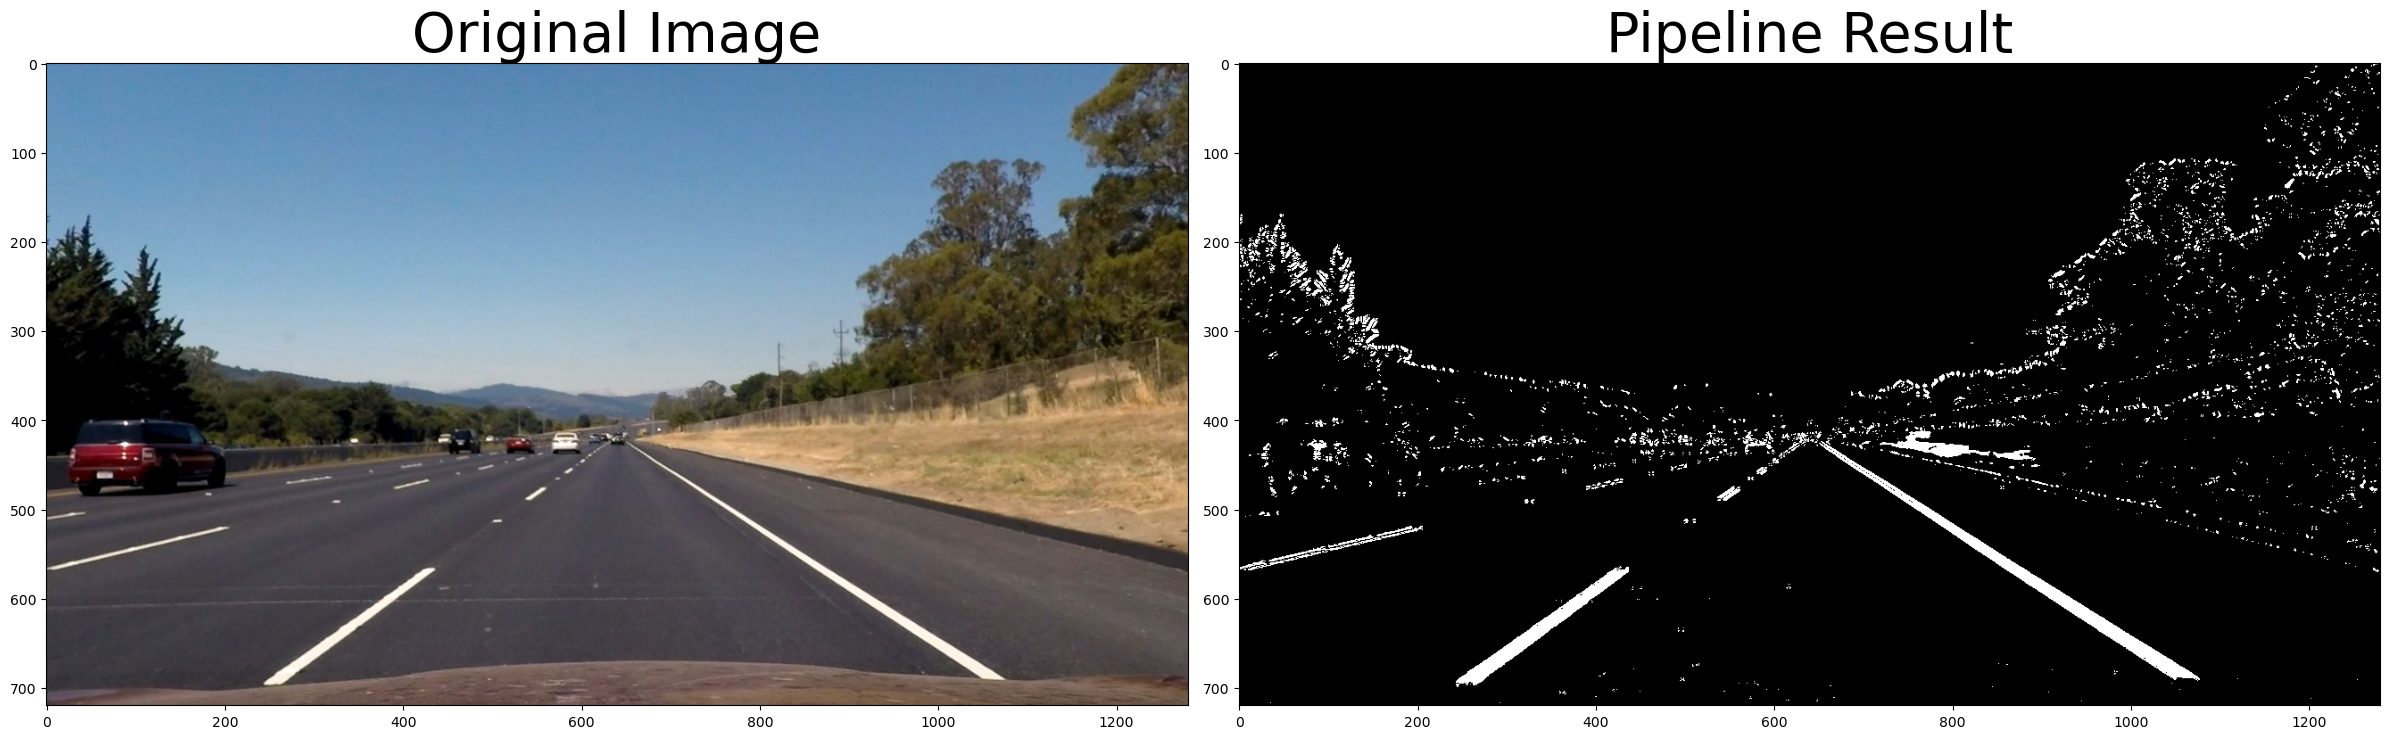

In [13]:
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/combined_filters.png')

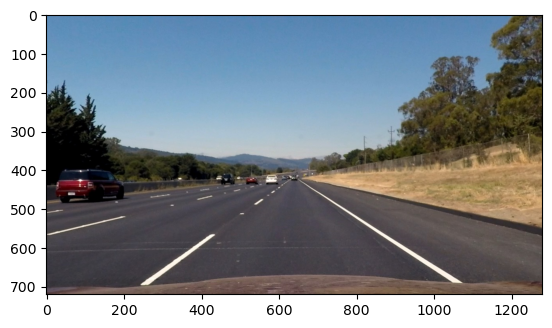

In [14]:
image = mpimg.imread('./test_images_UNUSED/straight_lines2.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)
plt.imshow(image);

In [79]:
## create source point suggestion for ROI
def create_roi_suggestions(image):
    ## "cropping" will be done by having the range of polgoin bottom left point between 720-520
    frame = cv.imread(image)
    frame = binary_pipeline(frame)
    x = frame.shape[1]
    y = frame.shape[0]

    result_source_points = np.array([[(1.0, 2.0), (3.0, 4.0), (5.0, 6.0), (7.0, 8.0)]],
               dtype=object)

    ## poly_size_collection = [(720, 180), (600, 180)]
    #project video

    polygon_size = [(720,230)]
    polgon_ratio= [0.35]
    polygon_ratio2 = [0.35]

    ## loop bottom left point
    ## TUNING: granular to have more centred Histograms
    for i in range(0,x-polygon_size[-1][0],10):
        for j in range(520,740,20):
            for size in polygon_size:
                for ratio in polgon_ratio:
                    result_source_points = np.append(result_source_points,[[
                        [i,j],
                        [size[0]* ratio + i,j-size[1]],
                        [i + size[0]* ratio + size[0] * polygon_ratio2[0] ,j-size[1]],
                        [i+size[0],j]
                    ]],axis=0)


    result_source_points = result_source_points[1:]
    ## return of source points
    return result_source_points

In [58]:
#image = cv.imread('./test_images_UNUSED/straight_lines2.jpg')
create_roi_suggestions('./test_images_UNUSED/straight_lines2.jpg')

array([[[0.0, 540.0],
        [380.0, 300.0],
        [760.0, 300.0],
        [948.0, 540.0]],

       [[0.0, 560.0],
        [380.0, 320.0],
        [760.0, 320.0],
        [948.0, 560.0]],

       [[0.0, 580.0],
        [380.0, 340.0],
        [760.0, 340.0],
        [948.0, 580.0]],

       ...,

       [[550.0, 680.0],
        [930.0, 440.0],
        [1310.0, 440.0],
        [1498.0, 680.0]],

       [[550.0, 700.0],
        [930.0, 460.0],
        [1310.0, 460.0],
        [1498.0, 700.0]],

       [[550.0, 720.0],
        [930.0, 480.0],
        [1310.0, 480.0],
        [1498.0, 720.0]]], dtype=object)

In [16]:
## Histograms, picking of the best roi

In [17]:
## written by Felix/Patrick
def reduce_noise(histogram):
    indices = np.where(lambda x: x < 30, histogram,None)
    filtered_hist = np.zeros_like(histogram)

    for i, value in enumerate(histogram):

        if value < 30:
            filtered_hist[i] = 0

        else:
            filtered_hist[i] = value
    return filtered_hist

In [18]:
## written by Felix/Patrick
## import ideal histogram
def import_ideal_histogram(histogram):
    with open('./histogram_sample/ideal_histogram.pickle', 'rb') as handle:
        ideal_histogram = pickle.load(handle)

    ## convert to fit compareHist type format
    histogram = histogram.astype(np.float32)
    ideal_histogram = ideal_histogram.astype(np.float32)
    histogram = histogram / 720
    ideal_histogram = ideal_histogram / 720
    ideal_histogram = np.expand_dims(ideal_histogram, axis=1)
    return histogram, ideal_histogram


In [19]:
## written by Felix/Patrick

## Explanation of metrics
# compare func with cv2 metric // lower is better
# CHI-SQUARE for good comparsons, lower is better
# CORRELATION for likeness in shape and patterns, Range 0-1, 1 is best and strongly correlated
# INTERSECTION for measuring the overlap between the detected lanes and the ideal lanes, range from 0 to the total number of pixels in the histograms, the higher has more overlap -> more similar
# BHATTACHARYYA for measuring the overall similarity of the distributions of the detected lanes and the ideal lanes, range from 0 to 1, 0 is best and most similar,1  is complettely different

def compare_histo(histogram, ideal_histogram):
    result_chi= cv.compareHist(histogram,ideal_histogram,cv.HISTCMP_CHISQR)
    result_cor= cv.compareHist(histogram,ideal_histogram,cv.HISTCMP_CORREL)
    result_int= cv.compareHist(histogram,ideal_histogram,cv.HISTCMP_INTERSECT)
    result_bha= cv.compareHist(histogram,ideal_histogram,cv.HISTCMP_BHATTACHARYYA)
    result_compare = (result_chi,result_cor,result_int,result_bha)
    return result_compare

In [20]:
## written by Felix/Patrick
def image_to_birds_eye(image,source_points):
    image = distort_correct(image,mtx,dist,camera_img_size)
    result = binary_pipeline(image)
    birdseye_result, inverse_perspective_transform = warp_image(result,source_points)
    return birdseye_result

In [21]:
## written by Felix/Patrick
def birds_eye_plotting(birdseye_result,image,source_points,histrogram , compare_result,spike1, spike2, spike3, spike4,comp1,comp2):
    # Plot the result
    f, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()

    # Plot the source image
    image_size = (image.shape[1], image.shape[0])
    x = image.shape[1]
    y = image.shape[0]
    source_points = np.int32(source_points)

    draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

    ax1.imshow(draw_poly)
    ax1.set_title('Source', fontsize=10)

    # Plot the destination image
    ax2.imshow(birdseye_result, cmap='gray')
    ax2.set_title('Destination', fontsize=10)

    # Plot the histogram
    ax3.set_ylim([0, 1])
    compare_result= [round(value, 2) for value in compare_result]
    ax3.plot(histrogram)
    ax3.set_title(compare_result, fontsize=10)


    comp1 = [round(value,2) for value in comp1]
    ax4.set_title(comp1, fontsize=10)
    ax4.plot(spike1, color='red')
    ax4.plot(spike2, color='green')


    comp2 = [round(value,2) for value in comp2]
    ax5.set_title(comp2, fontsize=10)
    ax5.plot(spike3, color='red')
    ax5.plot(spike4, color='green')

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.tight_layout()
    return f


In [22]:
## written by Felix/Patrick
def create_histogram(birds_eye_result):
    histogram = np.sum(birds_eye_result[int(birds_eye_result.shape[0]/2):,:], axis=0)
    histogram = histogram.astype(np.float32)
    histogram = np.expand_dims(histogram, axis=1)
    return histogram

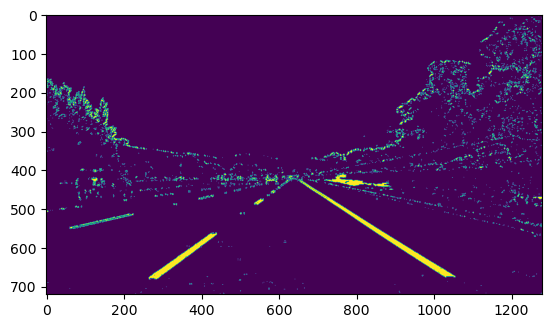

In [23]:
## written by Felix/Patrick
img = cv.imread('./test_images_UNUSED/straight_lines2.jpg')
img = binary_pipeline(img)
#image = mpimg.imread('./test_images_UNUSED/straight_lines1.jpg')
#image = distort_correct(image,mtx,dist,camera_img_size)
plt.imshow(img)

In [24]:
## written by Felix/Patrick
# gets the spikes of the histogram
def get_spikes(histogram):

    spike_positions = []
    spike_magnitudes = []

    spike = False
    for i in range(len(histogram)):
        if histogram[i] != 0 and spike == False:
            spike = True
            spike_positions.append((i, 0))
        elif histogram[i] == 0 and spike == True:
            spike = False
            spike_positions[-1] = (spike_positions[-1][0], i)

    for spike in spike_positions:
       spike_magnitudes.append(0)
       for i in range(spike[0], spike[1]):
           spike_magnitudes[-1] += histogram[i]

    spike1 = (0,0)
    spike2 = (0,0)

    max = 0
    for mag in spike_magnitudes:
        if mag > max:
            max = mag
            spike1 = spike_positions[spike_magnitudes.index(mag)]

    spike_magnitudes.pop(spike_positions.index(spike1))
    spike_positions.pop(spike_positions.index(spike1))

    max = 0
    for mag in spike_magnitudes:
        if mag > max:
            max = mag
            spike2 = spike_positions[spike_magnitudes.index(mag)]

    spike1 = histogram[spike1[0]:spike1[1]]
    spike2 = histogram[spike2[0]:spike2[1]]

    return spike1, spike2


In [25]:
## written by Felix/Patrick
## formates the histogram to the same length
def hist_pad_format(histo, ideal_histogram):
    unchanged_array = []
    if len(ideal_histogram) > len(histo):
        padded_array = np.zeros(len(ideal_histogram))
        unchanged_array = ideal_histogram
        for i in range(len(histo)):
            padded_array[(len(padded_array)- len(histo) ) // 2 + i-1] = (histo[i-1])
    elif len(ideal_histogram) < len(histo):
        padded_array = np.zeros(len(histo))
        unchanged_array = histo
        for i in range(len(ideal_histogram)):
            padded_array[(len(padded_array) - len(ideal_histogram)) // 2 + i-1] = (ideal_histogram[i-1])
    else:
        padded_array = histo
        unchanged_array = ideal_histogram

    result_array = np.expand_dims(padded_array, axis=1)
    result_array = result_array.astype(np.float32)
    return result_array, unchanged_array

In [26]:
## written by Felix/Patrick
# calculates the average of both spikes
def spike_compare_average(spike_1, ideal_spike_1, spike_2, ideal_spike_2):
        result_1 = compare_histo(spike_1, ideal_spike_1)
        result_2 = compare_histo(spike_2, ideal_spike_2)
        result_combined = ((result_1[0] + result_2[0]) / 2, (result_1[1] + result_2[1]) / 2, (result_1[2] + result_2[2]) / 2, (result_1[3] + result_2[3]) / 2)
        return result_combined


In [27]:
## written by Felix/Patrick
# plot function for the histogram with all metrics and spikes
def plot_all(histogram, comparison_result, source_point,spike1, spike2, spike3, spike4,comp1,comp2):
    img = cv.imread('./test_images_UNUSED/straight_lines2.jpg')
    birds_eye_result = image_to_birds_eye(img,source_point)

    result = birds_eye_plotting(birds_eye_result,img,source_point, histogram, comparison_result,spike1, spike2, spike3, spike4,comp1,comp2)

    return result

In [28]:
## written by Felix/Patrick
def get_best_roi(image,source_points):
    ## sources points loopen
    comparison_results = []
    histograms = []
    figures= []
    for current_source_points in source_points:


        birdseye_result = image_to_birds_eye(image, current_source_points)
        histogram = create_histogram(birdseye_result)
        histogram,ideal_histogram = import_ideal_histogram(histogram)


        histograms.append(histogram)
        if max(histogram) < 0.2:
            comparison_results.append((9999,0,0,9999))
            continue


        # Spike detection
        try:
            histo_spike_1, histo_spike_2 = get_spikes(histogram)
            ideal_histogram_spike_1, ideal_histogram_spike_2 = get_spikes(ideal_histogram)


            spike1, spike2 = hist_pad_format(histo_spike_1, ideal_histogram_spike_1)
            spike3, spike4 = hist_pad_format(histo_spike_2, ideal_histogram_spike_2)
            comp1 = compare_histo(spike1, spike2)
            comp2 = compare_histo(spike3, spike4)

            compare_hist = spike_compare_average(spike1, spike2, spike3, spike4)
            comparison_results.append(compare_hist)

        except(ValueError):
            comparison_results.append((9999,0,0,9999))
            continue



        #figures.append(plot_all(histogram, compare_hist, current_source_points,spike1,spike2,spike3,spike4, comp1, comp2))


    return comparison_results,histograms,source_points,figures

In [29]:
def warp_image(img, source_p):

    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    #the "order" of points in the polygon you are defining does not matter
    #but they need to match the corresponding points in destination_points!

    source_points = np.float32(source_p)

    destination_points = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])

    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)

    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)

    return warped_img, inverse_perspective_transform

In [ ]:
source_points_all = create_roi_suggestions('./test_images_UNUSED/straight_lines2.jpg')
frame = cv.imread('./test_images_UNUSED/straight_lines2.jpg')


comparison_results,histograms,source_points_after_roi,figures = get_best_roi(frame,source_points_all)

In [30]:
def get_index_of_best_roi(source_points, comparison_results):
    maxInter= -1
    index=0
    for i in comparison_results:
        if i[2] > maxInter:
            maxInter = i[2]
            index = comparison_results.index(i)

    #print(source_points[index])
    #print("index is:")
    #print(index)
    return index

In [ ]:
index = get_index_of_best_roi(source_points_after_roi, comparison_results)

In [ ]:
source_points_after_roi[index]

In [ ]:
#comparison_results

In [ ]:
## Lane topology

In [31]:
def resize_histogram(histogram):
    return histogram.astype(np.float32) / 720

In [32]:
def import_histogram(path):

    with open(path, 'rb') as handle:
        ideal_histogram = pickle.load(handle)

    ideal_histogram = resize_histogram(ideal_histogram)
    ideal_histogram = np.expand_dims(ideal_histogram, axis=1)


    return ideal_histogram

In [ ]:
def compare_histograms(hist1, hist2):
    min_intersection = 0
    max_intersection = 0

    bins = 10
    for i in range(bins):
        min_intersection += min(hist1[i], hist2[i])
        min_intersection += max(hist1[i], hist2[i])
    return min_intersection, max_intersection

In [72]:
def find_best_roi(image, source_points, ideal_histogram_path):


    comparison_results = []
    histograms = []
    # spike1 = []
    # spike2 = []
    # spike3 = []
    # spike4 = []
    # comp1 = []
    # comp2 = []

    for current_source_points in source_points:

        birdseye_result = image_to_birds_eye(image, current_source_points)
        histogram = create_histogram(birdseye_result)
        histogram = resize_histogram(histogram)
        ideal_histogram = import_histogram(ideal_histogram_path)


        histograms.append(histogram)
        if max(histogram) < 0.2:
            comparison_results.append((9999,0,0,9999))
            continue


        # Spike detection
        try:
            histo_spike_1, histo_spike_2 = get_spikes(histogram)
            ideal_histogram_spike_1, ideal_histogram_spike_2 = get_spikes(ideal_histogram)

            spike1, spike2 = hist_pad_format(histo_spike_1, ideal_histogram_spike_1)
            spike3, spike4 = hist_pad_format(histo_spike_2, ideal_histogram_spike_2)

            comp1 = compare_histo(spike1, spike2)
            comp2 = compare_histo(spike3, spike4)

            compare_hist = spike_compare_average(spike1, spike2, spike3, spike4)
            comparison_results.append(compare_hist)

        except(ValueError):
            comparison_results.append((9999,0,0,9999))
            continue

    best_comp_index = 0
    for i in range(len(comparison_results)):
        if comparison_results[i][2] > comparison_results[best_comp_index][2]:
            best_comp_index = i

    best_histogram = histograms[best_comp_index]
    plot_all(best_histogram, comparison_results[best_comp_index], source_points[best_comp_index], spike1, spike2, spike3, spike4, comp1, comp2)

    return comparison_results[best_comp_index], source_points[best_comp_index]

In [73]:
def choose_topology(topologies):

    maximum = max(topologies, key=lambda item:item[0][2])

    return maximum[1], maximum[2]

In [74]:
source_points = create_roi_suggestions('./test_images_UNUSED/straight_lines2.jpg')

In [75]:
image = cv.imread('./test_images_UNUSED/straight_lines2.jpg')

def detect_lane_topology():

    topologies = []

    comparison_results_straight, source_points_straight = find_best_roi(image, source_points, './histogram_sample/ideal_histogram.pickle')
    topologies.append((comparison_results_straight, source_points_straight, 'straight'))

    comparison_results_left_curve, source_points_left_curve = find_best_roi(image, source_points, './histogram_sample/left_curve_histogram_89.pickle')
    topologies.append((comparison_results_left_curve, source_points_left_curve, 'left'))

    comparison_results_right_curve, source_points_right_curve = find_best_roi(image, source_points, './histogram_sample/right_curve_histogram_37.pickle')
    topologies.append((comparison_results_right_curve, source_points_right_curve, 'right'))

    # print(source_points_straight)
    # print(source_points_left_curve)
    # print(source_points_right_curve)

    return choose_topology(topologies)

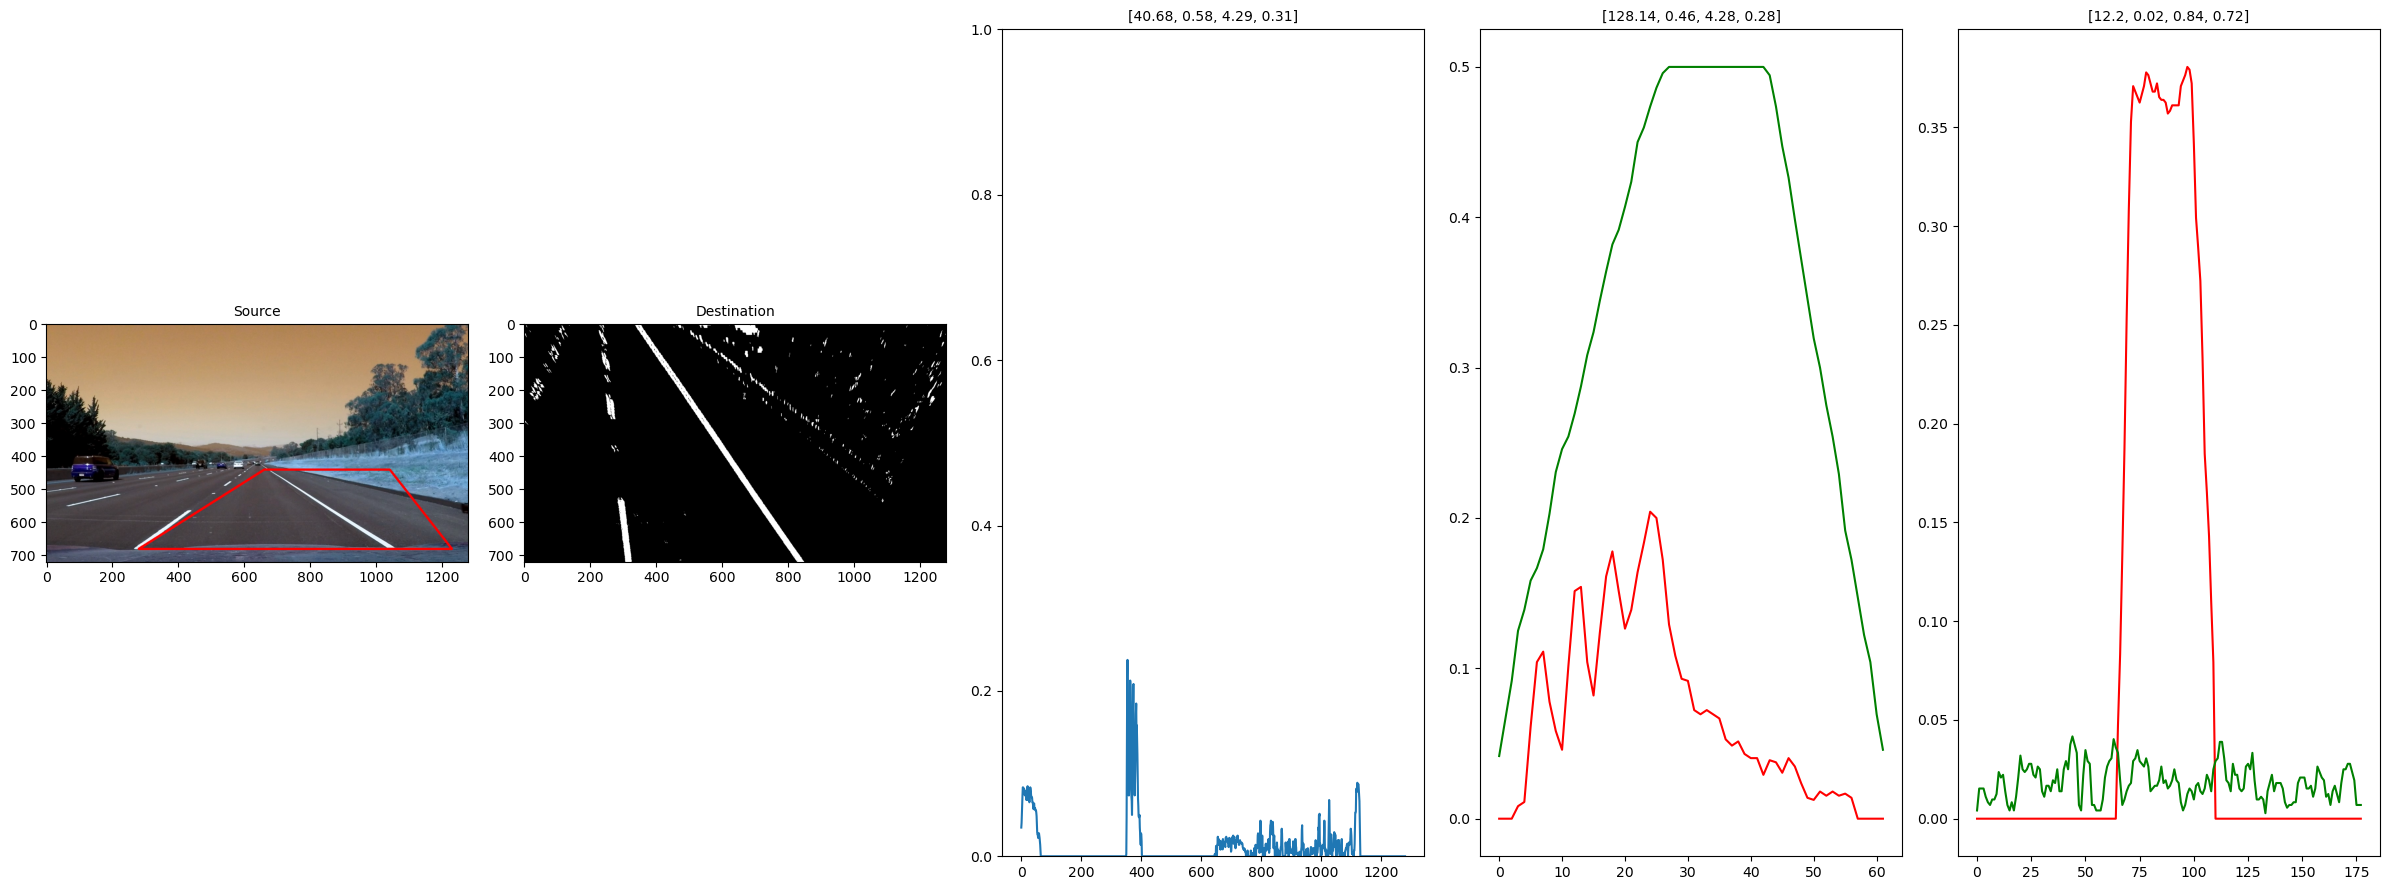

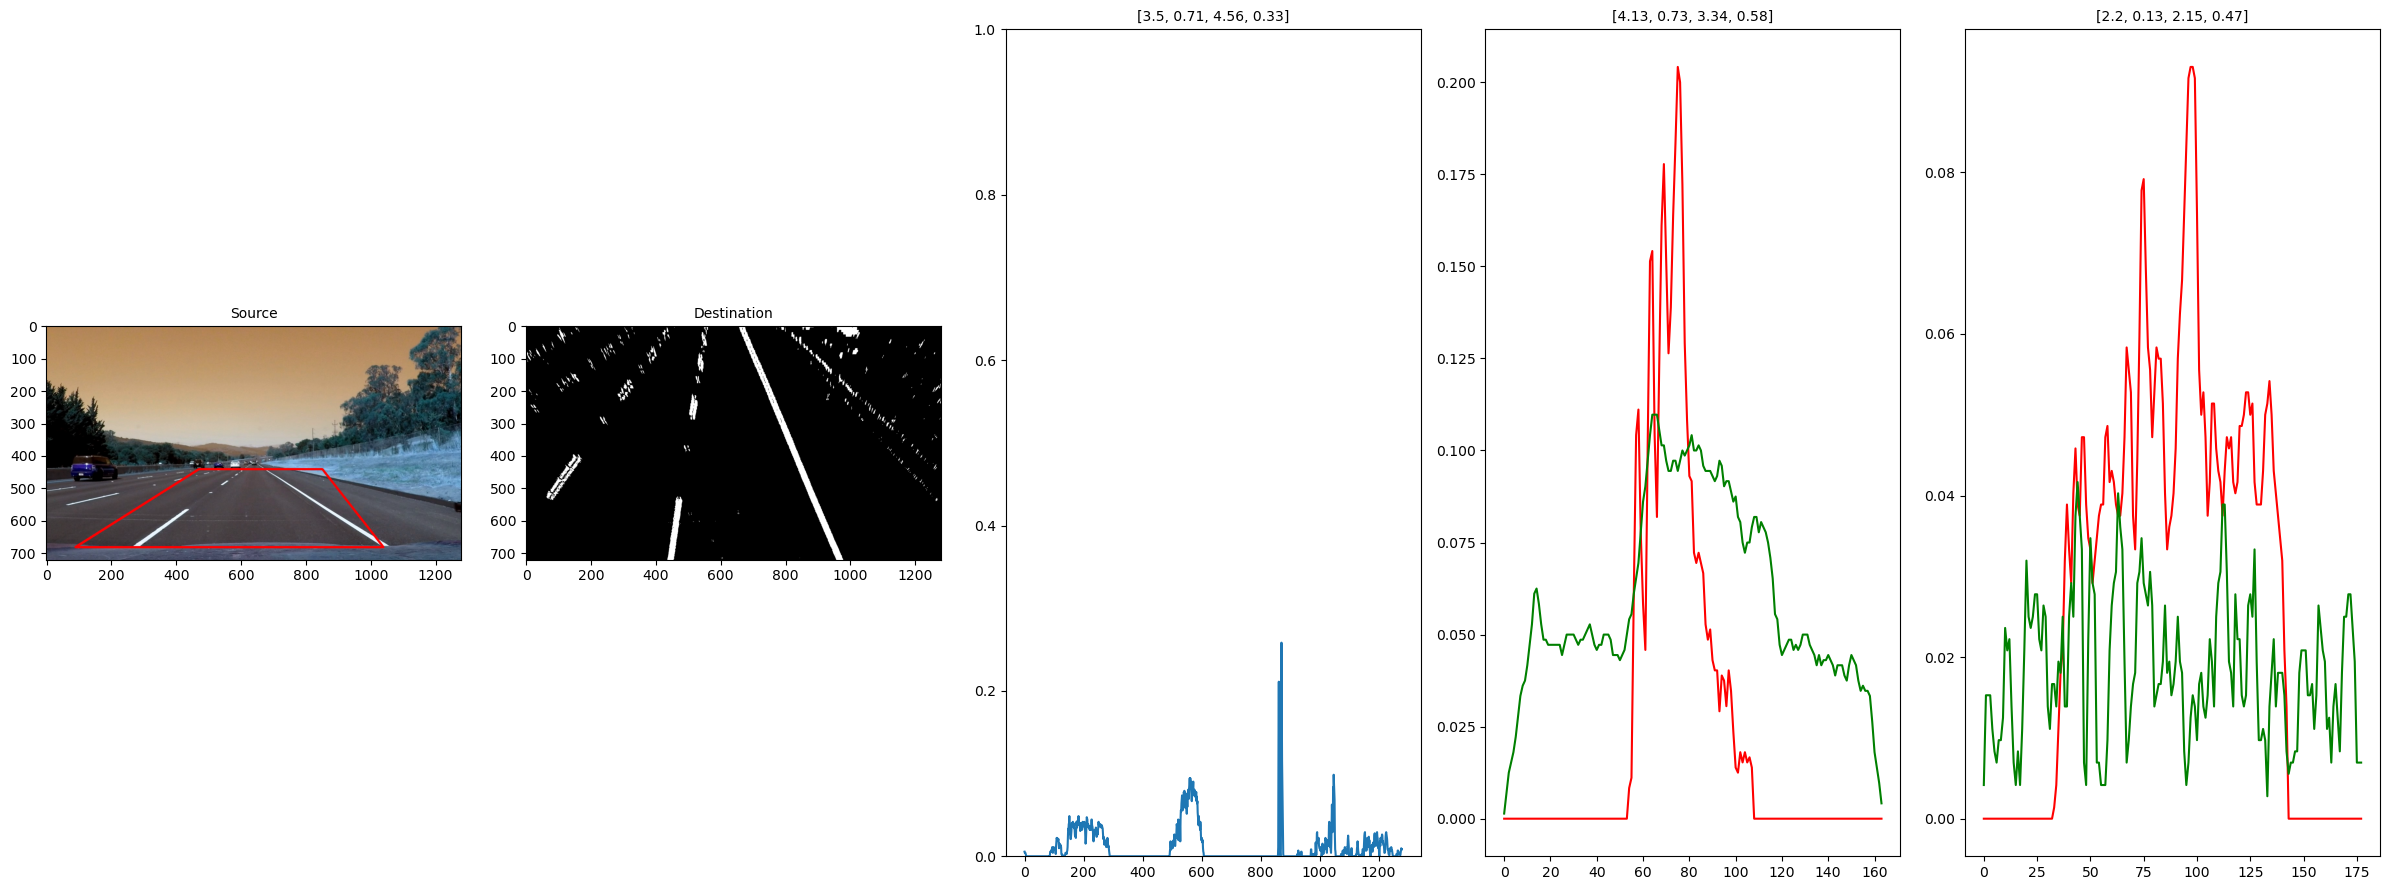

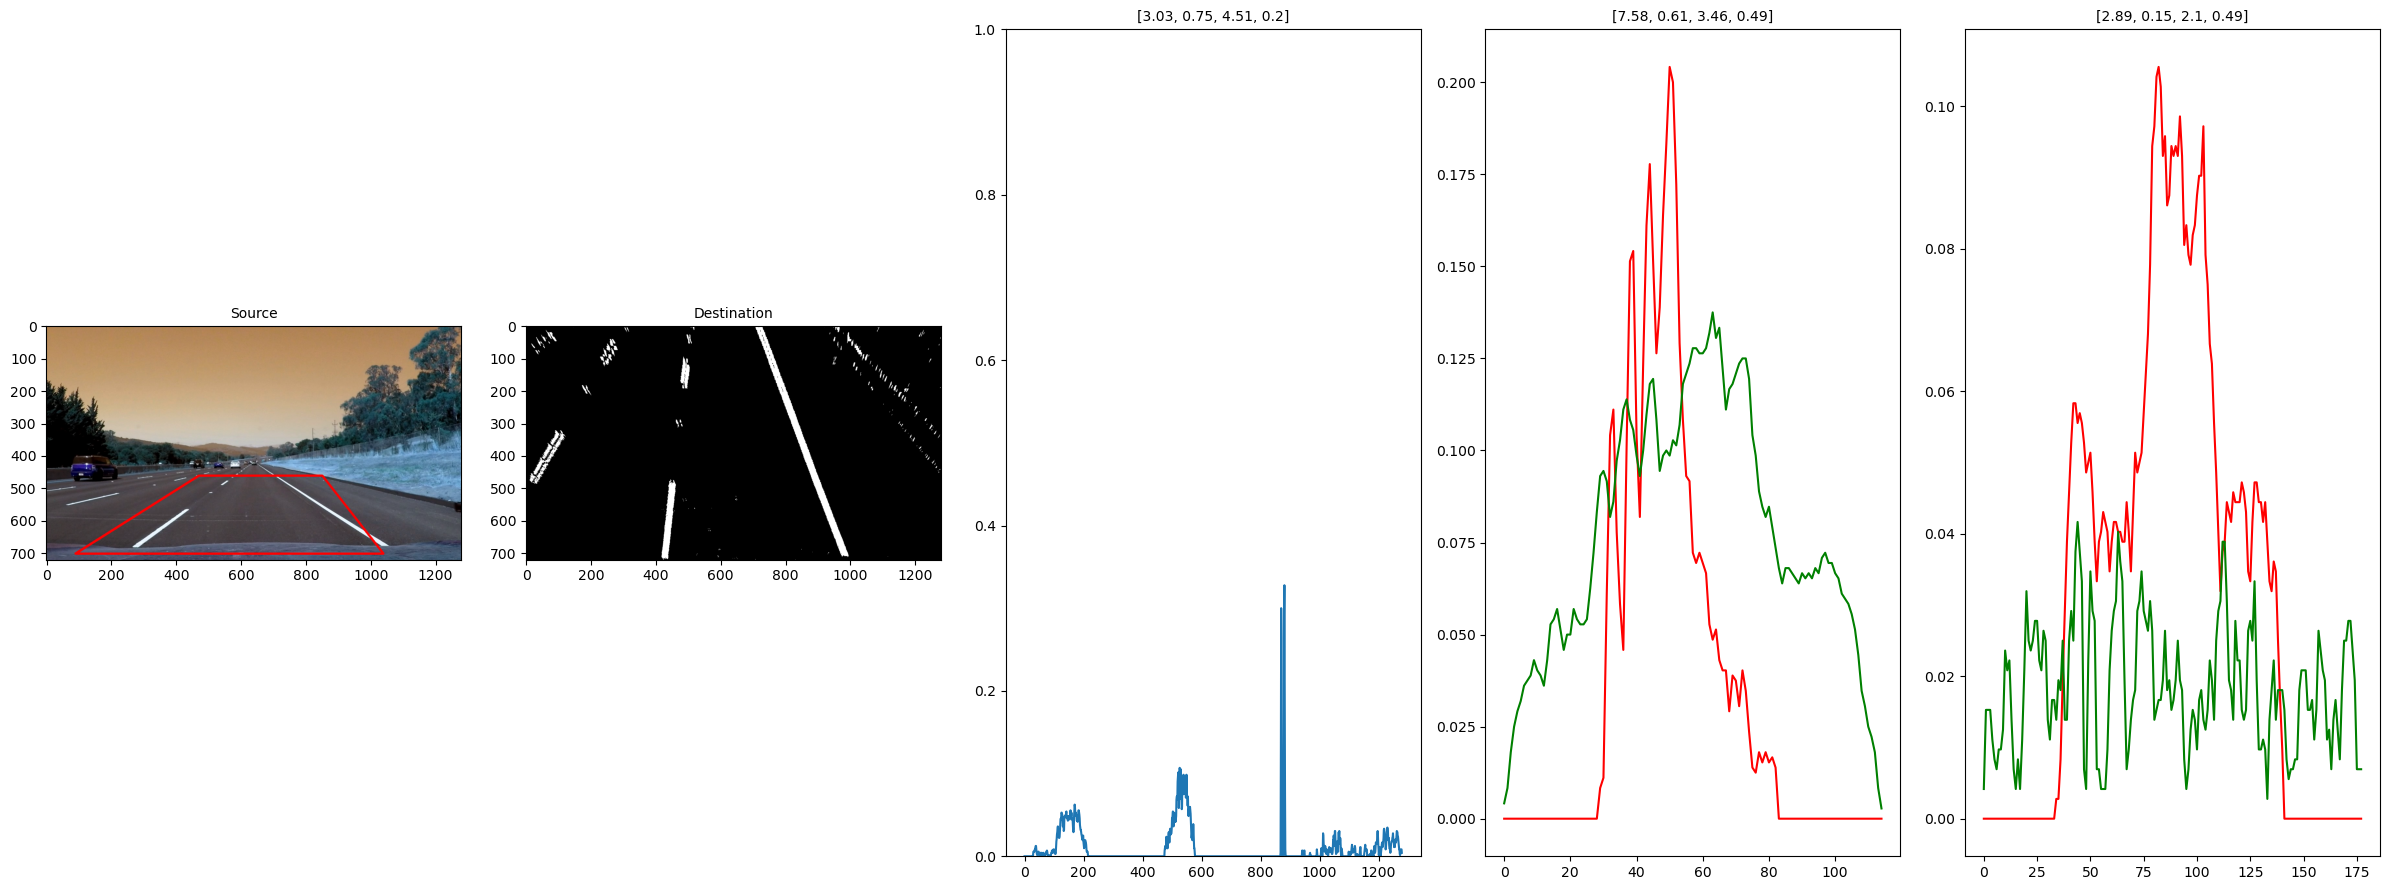

In [80]:
source_points_lane_topology, topology_name = detect_lane_topology()

In [81]:
topology_name

'left'

In [82]:
source_points_lane_topology

array([[90.0, 680.0],
       [470.0, 440.0],
       [850.0, 440.0],
       [1038.0, 680.0]], dtype=object)

In [ ]:
def create_curved_histogram(name):

    source_points = np.float32([
                [300, 720],
                [500, 600],
                [700, 600],
                [850, 720]
                ])

    curved_image = mpimg.imread(f'./curved_line_pictures/{name}.jpg')

    curved_birdseye_result = image_to_birds_eye(curved_image, source_points)

    histogram = np.sum(curved_birdseye_result[int(curved_birdseye_result.shape[0]/2):,:], axis=0)
    histogram = histogram.astype(np.float32)
    # histogram = cv.normalize(histogram, # input histogram
    #                             None, # output histogram (set to None to create a new array)
    #                             alpha=0, # lower range of the output histogram
    #                             beta=1, # upper range of the output histogram
    #                             norm_type=cv.NORM_MINMAX) # normalization type
    plt.figure()
    plt.plot(histogram)
    plt.savefig(f'./curved_line_histograms/{name}.png')

    with open(f'./curved_line_histograms_pickled/{name}.pickle', 'wb') as handle:
        pickle.dump(histogram, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def create_curved_histograms_from_archive():
    #left curve
    for i in range(98):
        create_curved_histogram(f'left_curve/left curve ({i})')

    #right curve
    for i in range(46):
        create_curved_histogram(f'right_curve/right_curve ({i})')

In [ ]:
birdseye_result, inverse_perspective_transform = warp_image(result, source_points_all[index])

# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image.shape[1], image.shape[0])
x = image.shape[1]
y = image.shape[0]
source_points = np.int32(source_points_after_roi[index])

draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/perspective_transform.png')

In [ ]:
image = mpimg.imread('./test_images_UNUSED/straight_lines2.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)

In [ ]:
histogram = np.sum(birdseye_result[int(birdseye_result.shape[0]/2):,:], axis=0)
plt.figure();
plt.plot(histogram);
plt.savefig('saved_figures/lane_histogram.png')

In [ ]:
def track_lanes_initialize(binary_warped):

    global window_search

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3)
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

In [ ]:
left_fit,right_fit = track_lanes_initialize(birdseye_result)

In [ ]:
Image('saved_figures/01_window_search.png')

In [ ]:
def track_lanes_update(binary_warped, left_fit,right_fit):

    global window_search
    global frame_count

    # repeat window search to maintain stability
    if frame_count % 10 == 0:
        window_search=True


    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    return left_fit,right_fit,leftx,lefty,rightx,righty

In [ ]:
global frame_count
frame_count=0
left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye_result, left_fit,right_fit)

In [ ]:
Image('saved_figures/02_updated_search_window.png')

In [ ]:
# A function to get quadratic polynomial output
def get_val(y,poly_coeff):
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

In [ ]:
def lane_fill_poly(binary_warped,undist,left_fit,right_fit):

    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane
    cv.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp using inverse perspective transform
    newwarp = cv.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0]))
    # overlay
    #newwarp = cv.cvtColor(newwarp, cv.COLOR_BGR2RGB)
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

In [ ]:
colored_lane = lane_fill_poly(birdseye_result, image, left_fit, right_fit)
plt.figure()
plt.imshow(colored_lane);
plt.tight_layout()
plt.savefig('saved_figures/lane_polygon.png')

In [ ]:
def measure_curve(binary_warped,left_fit,right_fit):

    # generate y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # measure radius at the maximum y value, or bottom of the image
    # this is closest to the car
    y_eval = np.max(ploty)

    # coversion rates for pixels to metric
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # x positions lanes
    leftx = get_val(ploty,left_fit)
    rightx = get_val(ploty,right_fit)

    # fit polynomials in metric
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # calculate radii in metric from radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # averaged radius of curvature of left and right in real world space
    # should represent approximately the center of the road
    curve_rad = round((left_curverad + right_curverad)/2)

    return curve_rad

In [ ]:
measure_curve(birdseye_result,left_fit, right_fit)

In [ ]:
def vehicle_offset(img,left_fit,right_fit):

    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    xm_per_pix = 3.7/700
    image_center = img.shape[1]/2

    ## find where lines hit the bottom of the image, closest to the car
    left_low = get_val(img.shape[0],left_fit)
    right_low = get_val(img.shape[0],right_fit)

    # pixel coordinate for center of lane
    lane_center = (left_low+right_low)/2.0

    ## vehicle offset
    distance = image_center - lane_center

    ## convert to metric
    return (round(distance*xm_per_pix,5))

In [ ]:
offset = vehicle_offset(colored_lane, left_fit, right_fit)
print(offset)

In [ ]:
def img_pipeline(img):

    global window_search
    global left_fit_prev
    global right_fit_prev
    global frame_count
    global curve_radius
    global offset

    # load camera matrix and distortion matrix
    camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
    mtx = camera['mtx']
    dist = camera['dist']
    camera_img_size = camera['imagesize']

    #correct lens distortion
    undist = distort_correct(img,mtx,dist,camera_img_size)
    # get binary image
    binary_img = binary_pipeline(undist)

    index_of_best_roi = get_index_of_best_roi(source_points_lane_topology, comparison_results)
    birdseye, inverse_perspective_transform = warp_image(binary_img, source_points_lane_topology)

    #perspective transform
    #birdseye, inverse_perspective_transform = warp_image(binary_img, source_points_all[index])

    if window_search:
        #window_search = False
        #window search
        left_fit,right_fit = track_lanes_initialize(birdseye)
        #store values
        left_fit_prev = left_fit
        right_fit_prev = right_fit

    else:
        #load values
        left_fit = left_fit_prev
        right_fit = right_fit_prev
        #search in margin of polynomials
        left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye, left_fit,right_fit)

    #save values
    left_fit_prev = left_fit
    right_fit_prev = right_fit

    #draw polygon
    processed_frame = lane_fill_poly(birdseye, undist, left_fit, right_fit)

    #update ~twice per second
    if frame_count==0 or frame_count%15==0:
        #measure radii
        curve_radius = measure_curve(birdseye,left_fit,right_fit)
        #measure offset
        offset = vehicle_offset(undist, left_fit, right_fit)


    #printing information to frame
    font = cv.FONT_HERSHEY_TRIPLEX
    processed_frame = cv.putText(processed_frame, 'Radius: '+str(curve_radius)+' m', (30, 40), font, 1, (0,255,0), 2)
    processed_frame = cv.putText(processed_frame, 'Offset: '+str(offset)+' m', (30, 80), font, 1, (0,255,0), 2)

    frame_count += 1
    return processed_frame

In [ ]:
filenames = os.listdir("test_images_UNUSED/")
global window_search
global frame_count
for filename in filenames:
    frame_count = 15
    window_search = True
    image = mpimg.imread('test_images_UNUSED/'+filename)
    lane_image = img_pipeline(image)
    mpimg.imsave('output_images/lane3_'+filename,lane_image)

In [ ]:
Image('output_images/lane3_straight_lines2.jpg')

In [ ]:
global window_search
global frame_count
window_search = True
frame_count = 0

#chicago footage
for filename in ['project_video.mp4']:
    clip = VideoFileClip('videos/'+filename)#.subclip((3,25),(3,35))
    #clip_crop = crop(clip, x1=320, y1=0, x2=1600, y2=720)
    out= clip.fl_image(img_pipeline)
    #out = clip_crop.fl_image(img_pipeline)
    out.write_videofile('output_videos/processed2_FINAL_'+filename, audio=False, verbose=False)
    print('Success!')